In [1]:
import pandas as pd
import numpy as np
import pickle
import janitor

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

In [2]:
with open('raw-data/san-pedro-201906-202006.pkl', 'rb') as file:
    sp = pickle.load(file)

with open('raw-data/centro-201701-202106.pkl', 'rb') as file:
    centro = pickle.load(file)

with open('data/measurement-units.pkl', 'rb') as file:
    measurement_units = pickle.load(file)


### Outlier elimination

In [3]:
sp = (
      sp
      .pipe(janitor.transform_column, column_name='rainf',
            function=lambda rainf: rainf.where(
                  (rainf.index < '2019-8-25') | (rainf.index > '2019-9-6'), np.nan),
            elementwise=False)
      .pipe(janitor.transform_column, column_name='wsr',
            function=lambda wsr: wsr.where(wsr.index < '2021-3-23', np.nan),
            elementwise=False)
)


In [4]:
limits = pd.Series({
    'co': 26,
    'no': 210,
    'no2': 210,
    'nox': 210,
    'o3': 90,
    'pm10': 70,
    'pm2_5': 41,
    'so2': 75,
    'prs': 760,
    'rainf': 130,
    'rh': 100,
    'sr': 1,
    'tout': 45,
    'wdr': 360,
    'wsr': 117,
}) # Maximum value that variables can take according to the Mexican normatives of air quality

sp = sp.apply(lambda row: row.where(row < limits, np.nan), axis=1)

### Imputation

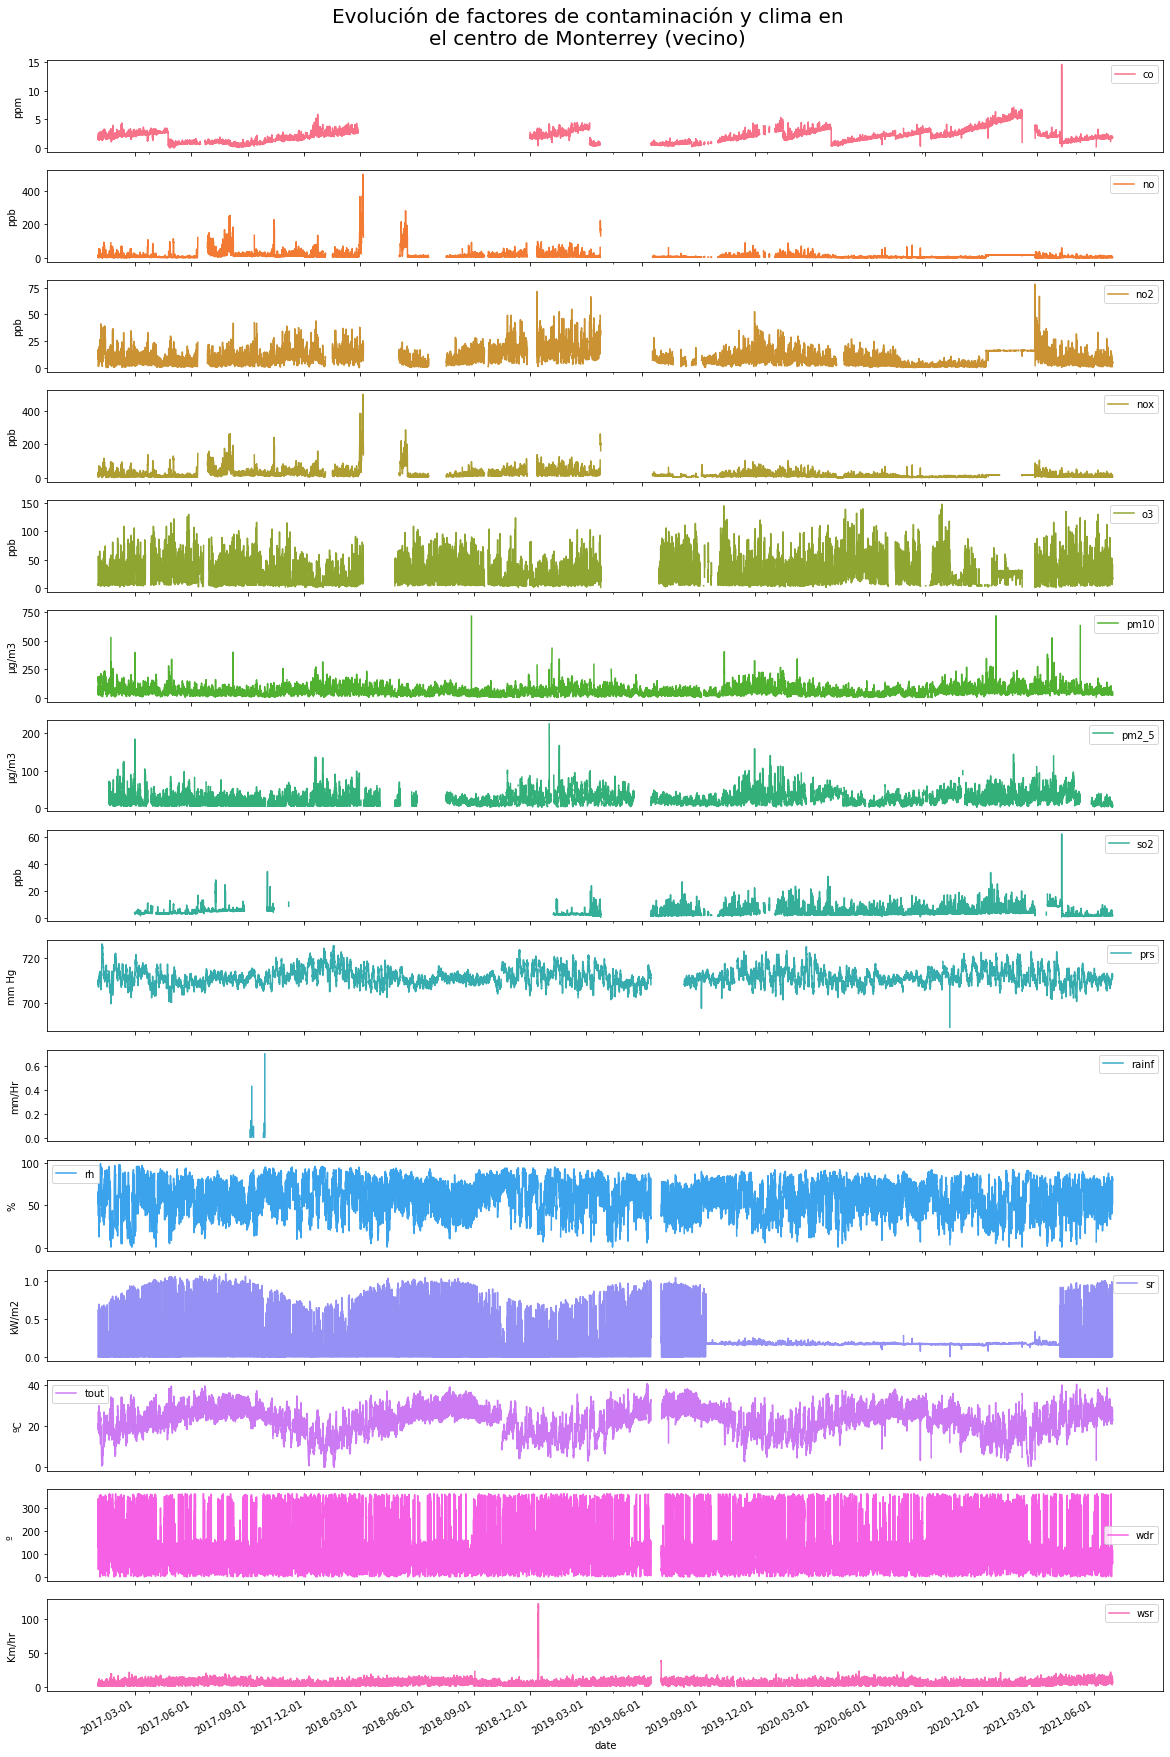

In [5]:
palette = sns.husl_palette(n_colors=15)

kwargs = {'subplots': True,
          'figsize': (20, 30),
          'sharex': True,
          'xticks': pd.date_range(centro.index.min(), centro.index.max(), freq='Q').strftime("%Y-%b").tolist(),
          'colormap': ListedColormap(palette.as_hex())
          }

axes = centro.plot(**kwargs)

for ax in axes:
    factor = ax.get_legend().get_texts()[0]._text
    ax.set_ylabel(measurement_units[factor])

fig = axes[0].get_figure()  # All Axes contain the 15 subplots as figure
_ = fig.suptitle(
    'Evolución de factores de contaminación y clima en\nel centro de Monterrey (vecino)', fontsize=20)
fig.subplots_adjust(top=0.955)


In [6]:
centro = centro.apply(lambda row: row.where(row < limits, np.nan), axis=1)

In [7]:
# Imputate missing values from centro

sp = (
    sp
    .pipe(janitor.fill_empty, column_names='no', value=centro.no)
    .pipe(janitor.fill_empty, column_names='no2', value=centro.no2)
    .pipe(janitor.fill_empty, column_names='nox', value=centro.nox)
    .pipe(janitor.fill_empty, column_names='rainf', value=0) # There was no rain
)

# Rolling statistic and first days with mean

sp = (
    sp
    .fillna(sp.rolling(24*7*12, min_periods=1, closed='both').mean())
    .fillna(sp.mean())
)

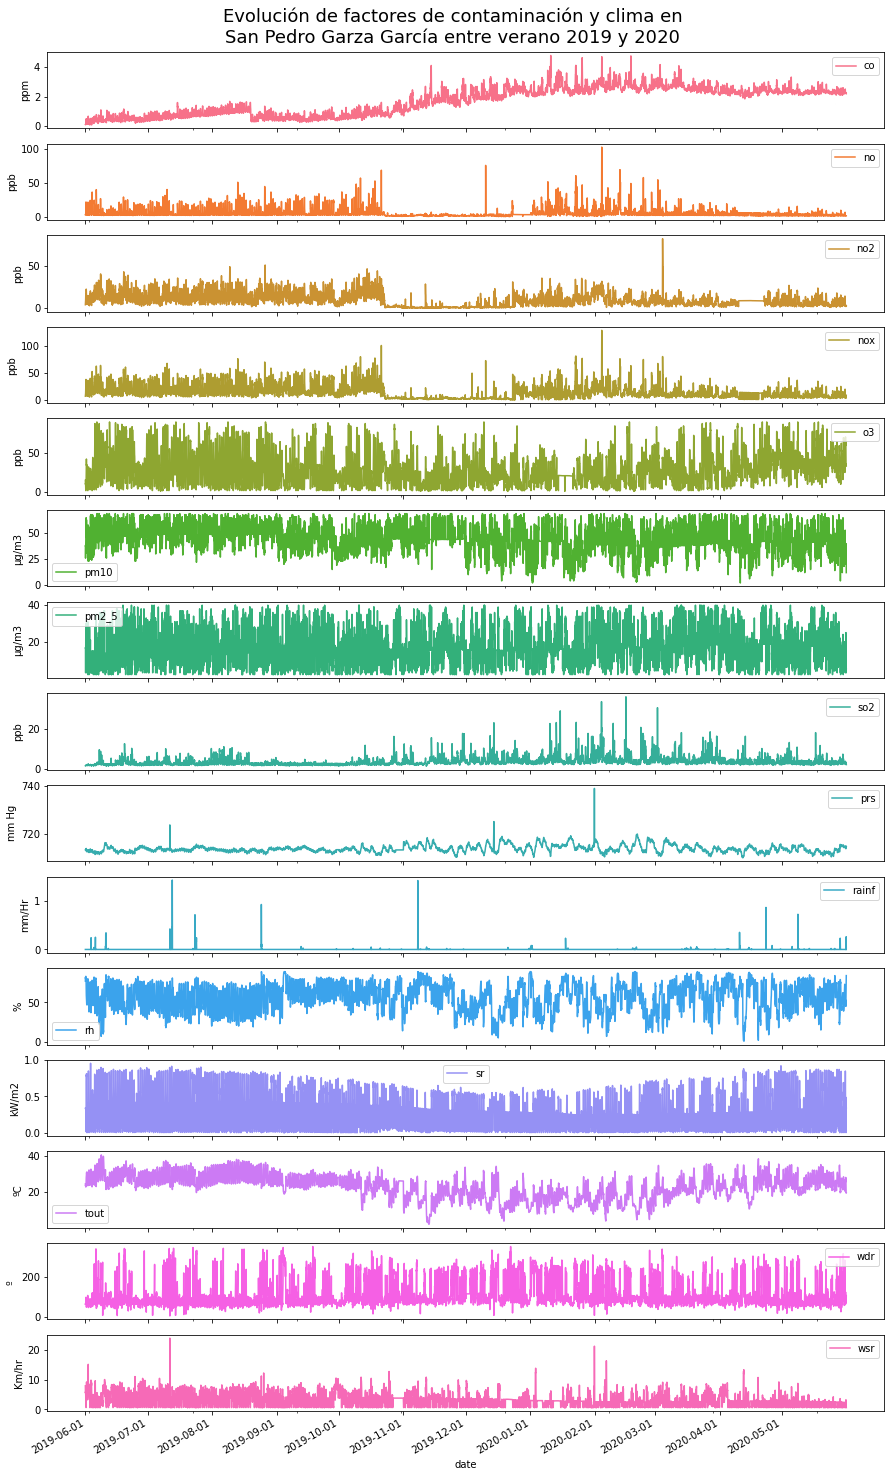

In [8]:
palette = sns.husl_palette(n_colors=15)

kwargs = {'subplots': True,
          'figsize': (15, 25),
          'sharex': True,
          'xticks': pd.date_range(sp.index.min(), sp.index.max(), freq='M').strftime("%Y-%b").tolist(),
          'colormap': ListedColormap(palette.as_hex())
          }

axes = sp.plot(**kwargs)

for ax in axes:
    factor = ax.get_legend().get_texts()[0]._text
    ax.set_ylabel(measurement_units[factor])

fig = axes[0].get_figure()  # All Axes contain the 15 subplots as figure
_ = fig.suptitle(
    'Evolución de factores de contaminación y clima en\nSan Pedro Garza García entre verano 2019 y 2020', fontsize=18)
fig.subplots_adjust(top=0.955)


In [9]:
with open('data/san-pedro.pkl', 'wb') as file:
    pickle.dump(sp, file)